
# Analyzing Job Characteristics and Salary Predictions

This notebook performs:

- Data loading and cleaning
- Title categorization
- EDA visualizations
- Classification with SMOTE & GridSearchCV
- Regression with GridSearchCV
- Result visualizations


In [3]:

# Install and import libraries
%pip install imbalanced-learn==0.9.1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack, csr_matrix


Note: you may need to restart the kernel to use updated packages.



## 1) Load & Clean Data


In [4]:

# Load dataset
df = pd.read_csv('C:/Users/smyou/Downloads/LinkedIn/LinkedInJobs_MLDataset.csv')
# Drop missing salary/title/description
df = df.dropna(subset=['base_comp','Job_Ttl','Job_Desc'])
# Convert types
df['base_comp'] = pd.to_numeric(df['base_comp'], errors='coerce')
df['is_sponsored'] = df['is_sponsored'].astype(int)
df['is_remote'] = df['is_remote'].astype(int)
# Final drop
df = df.dropna(subset=['base_comp'])
print('Cleaned dataset shape:', df.shape)
df.head()


Cleaned dataset shape: (33244, 24)


,Co_Nm,Co_Pg_Lstd,Emp_Cnt,Flw_Cnt,Job_Ttl,Job_Desc,Is_Supvsr,max_sal,med_sal,min_sal,...,st_code,is_remote,views,app_typ,app_is_off,xp_lvl,domain,has_post_domain,is_sponsored,base_comp
0,HearingLife,True,1171,11417,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,False,5250.00,5250.00,5250.00,...,SC,0,9,OffsiteApply,True,Entry level,careers-demant.icims.com,True,0,1
1,"Metalcraft of Mayville, Inc.",True,300,2923,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,False,0.00,0.00,0.00,...,WI,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
2,"U.S. Tsubaki Power Transmission, LLC",True,314,8487,"Manager, Engineering",The TSUBAKI name is synonymous with excellence...,True,0.00,0.00,0.00,...,AL,0,0,OffsiteApply,True,Not Listed,www.click2apply.net,True,0,0
3,Episcopal Communities & Services,True,36,305,Cook,descriptionTitle\n\n Looking for a great oppor...,False,22.27,22.27,22.27,...,CA,0,1,OffsiteApply,True,Entry level,jobs.apploi.com,True,0,1
4,"iHerb, LLC",True,1227,51933,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",False,275834.00,240895.00,205956.00,...,XF,1,0,OffsiteApply,True,Mid-Senior level,careers.iherb.com,True,0,1



## 2) Title Categorization & EDA


job_cat
Other        21528
Manager       5116
Engineer      3262
Analyst       1528
Nurse         1122
Developer      688
Name: count, dtype: int64


c:\Users\smyou\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


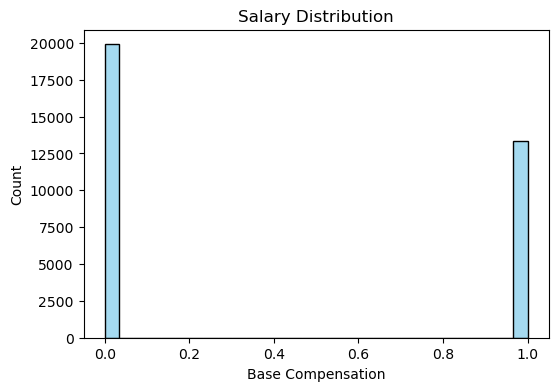

In [5]:

# Map job titles to categories
def map_title(t):
    t = t.lower()
    if 'engineer' in t: return 'Engineer'
    if 'manager' in t:  return 'Manager'
    if 'nurse' in t:    return 'Nurse'
    if 'analyst' in t:  return 'Analyst'
    if 'developer' in t: return 'Developer'
    return 'Other'

df['job_cat'] = df['Job_Ttl'].apply(map_title)
print(df['job_cat'].value_counts())

# Plot salary distribution
plt.figure(figsize=(6,4))
sns.histplot(df['base_comp'], bins=30, color='skyblue')
plt.title('Salary Distribution')
plt.xlabel('Base Compensation')
plt.show()



## 3) Classification: SMOTE & GridSearchCV


In [ ]:

# Prepare classification features
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['Job_Desc'].fillna(''))
X_num = df[['Emp_Cnt','Flw_Cnt','views','is_remote']].fillna(0).astype(float)
X_cls = hstack([X_text, csr_matrix(X_num.values)])
y_cls = df['job_cat']

# Split (stratify)
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)
# SMOTE on train only
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(Xc_tr, yc_tr)
print('After SMOTE class counts:', pd.Series(y_res).value_counts())

# GridSearchCV on GBDT
param_grid = {'n_estimators':[50,100], 'learning_rate':[0.1,0.2], 'max_depth':[2,3]}
gbc = GradientBoostingClassifier(random_state=42)
gs_cls = GridSearchCV(gbc, param_grid, scoring='roc_auc_ovr', cv=3, n_jobs=-1)
gs_cls.fit(X_res, y_res)
print('Best Classifier Params:', gs_cls.best_params_)

# Evaluate
best_clf = gs_cls.best_estimator_
y_pred = best_clf.predict(Xc_te)
y_proba = best_clf.predict_proba(Xc_te)
print(classification_report(yc_te, y_pred))
print('Macro ROC AUC:', roc_auc_score(yc_te, y_proba, multi_class='ovr'))


After SMOTE class counts: job_cat
Analyst      17222
Manager      17222
Other        17222
Engineer     17222
Developer    17222
Nurse        17222
Name: count, dtype: int64



## 4) Regression: GridSearchCV


In [ ]:

# Prepare regression features
X_reg = X_cls  # reuse text+numeric
y_reg = df['base_comp']
# Split
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# GridSearchCV on GBDT Regressor
reg_pipe = Pipeline([('reg', GradientBoostingRegressor(random_state=42))])
param_grid_reg = {'reg__n_estimators':[100,150], 'reg__learning_rate':[0.05,0.1], 'reg__max_depth':[2,3]}
gs_reg = GridSearchCV(reg_pipe, param_grid_reg, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs_reg.fit(Xr_tr, yr_tr)
print('Best Regressor Params:', gs_reg.best_params_)

# Evaluate
best_reg = gs_reg.best_estimator_
y_pred_reg = best_reg.predict(Xr_te)
print('Test MSE:', mean_squared_error(yr_te, y_pred_reg))



## 5) Results Visualization


In [ ]:

# Confusion matrix
t from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yc_te, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_clf.classes_, yticklabels=best_clf.classes_)
plt.title('Classification Confusion Matrix')
plt.show()

# Regression scatter
plt.figure(figsize=(5,5))
plt.scatter(yr_te, y_pred_reg, alpha=0.3)
mn, mx = yr_te.min(), yr_te.max()
plt.plot([mn,mx],[mn,mx], 'r--')
plt.title('Actual vs Predicted Salary')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
